In [1]:
import os
import re
import pandas as pd
import numpy as np
import scanpy as sc
import gseapy as gp  # for ssGSEA
import seaborn as sns
import matplotlib.pyplot as plt
import tempfile
import shutil
import pickle
with open("signatures_CD8.pkl", "rb") as f:
    sigs_CD8 = pickle.load(f)

print({k: len(v) for k, v in sigs_CD8.items()})

with open("signatures_CD4.pkl", "rb") as f:
    sigs_CD4 = pickle.load(f)

print({k: len(v) for k, v in sigs_CD4.items()})

data_dir = "GSE288199_raw"

{'Lowery_pos_243g': 243, 'Oliveira_TTE_100g': 100, 'Oliveira_pos_74g': 74, 'Yost_CD8_Exh_100g': 100, 'Hanada_pos_27g': 27, 'Lowery_neg_99g': 99, 'Oliveira_virus_26g': 26, 'Hanada_neg_5g': 5}
{'Lowery_pos_40g': 40, 'Jansen_TermDiff_73g': 73, 'Caushi_Tfh2_66g': 66, 'Oh_CXCL13_50g': 50, 'Hanada_pos_9g': 9, 'Lowery_neg_37g': 37, 'Hanada_neg_4g': 4}


In [2]:
sample_dirs = [d for d in os.listdir(data_dir)
               if os.path.isdir(os.path.join(data_dir, d))]

In [3]:
def read_10x_custom(sample_dir, var_names='gene_symbols'):
    """
    Use sc.read_10x_mtx() on a folder that has nonstandard 10x filenames by
    copying them into a temporary folder (with the standard 10x names).
    """
    
    # Find the files in sample_dir that end with _matrix.mtx.gz, etc.
    filenames = os.listdir(sample_dir)
    mtx_file  = [f for f in filenames if f.endswith("_matrix.mtx.gz")]
    bc_file   = [f for f in filenames if f.endswith("_barcodes.tsv.gz")]
    feat_file = [f for f in filenames if f.endswith("_features.tsv.gz")]

    if not (mtx_file and bc_file and feat_file):
        raise FileNotFoundError(
            f"Could not find matrix/barcodes/features in {sample_dir} with the suffixes:"
            " _matrix.mtx.gz, _barcodes.tsv.gz, _features.tsv.gz"
        )

    mtx_path  = os.path.join(sample_dir, mtx_file[0])
    bc_path   = os.path.join(sample_dir, bc_file[0])
    feat_path = os.path.join(sample_dir, feat_file[0])

    # Create a temp folder
    tmpdir = tempfile.mkdtemp(prefix="10x_temp_")
    try:
        # Copy the three files with standard 10x names
        shutil.copy(mtx_path,  os.path.join(tmpdir, "matrix.mtx.gz"))
        shutil.copy(bc_path,   os.path.join(tmpdir, "barcodes.tsv.gz"))
        shutil.copy(feat_path, os.path.join(tmpdir, "features.tsv.gz"))

        # Now read_10x_mtx will see them as the standard 10x file names
        adata = sc.read_10x_mtx(
            tmpdir, 
            var_names=var_names, 
            make_unique=True
        )
    finally:
        # Clean up the temp directory
        shutil.rmtree(tmpdir)

    return adata

In [4]:
import scanpy as sc

# List to store the processed AnnData objects
adatas = []

for s1 in sample_dirs:
    # Read and preprocess each sample
    adata = read_10x_custom(f'GSE288199_raw/{s1}')
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    new_index = [bc.rsplit('-', 1)[0] + f"-{s1}" for bc in adata.obs.index]
    adata.obs.index = new_index
    
    # Append the AnnData object to the list
    adatas.append(adata)

# Concatenate all adatas into one single AnnData object
adata_concat = sc.concat(adatas, label='batch', keys=sample_dirs, join='inner')
        
   

In [5]:
adata_concat

AnnData object with n_obs × n_vars = 425770 × 33545
    obs: 'batch'

In [6]:
predicted = pd.read_csv("cell_type.csv", index_col="cell_barcode")
predicted

,cell_type
cell_barcode,
AAACCTGAGATCCGAG-HN12_post,CD4
AAACCTGAGGCTAGCA-HN12_post,CD4
AAACCTGCAGCATGAG-HN12_post,CD4
AAACCTGGTTCCACAA-HN12_post,CD4
AAACCTGTCAAAGTAG-HN12_post,CD8
...,...
TTTGTCAAGGAGTCTG-HN35_post,CD4
TTTGTCACATCACCCT-HN35_post,CD4
TTTGTCACATTTGCTT-HN35_post,CD4


In [7]:

all_genes_flat_CD8 = [item for sublist in sigs_CD8.values() for item in sublist]
all_genes_flat_CD4 = [item for sublist in sigs_CD4.values() for item in sublist]
subset_genes_CD8 = list(set(all_genes_flat_CD8))
subset_genes_CD4 = list(set(all_genes_flat_CD4))

In [8]:
matched_genes_CD8 = []
matched_genes_CD4 = []

for s1 in subset_genes_CD8:
    if s1 in adata_concat.var.index:
        matched_genes_CD8.append(s1)
for s1 in subset_genes_CD4:
    if s1 in adata_concat.var.index:
        matched_genes_CD4.append(s1)    
# Print match info
print(f" {len(matched_genes_CD4)}/{len(subset_genes_CD4)} CD4 genes are found.")
print(f" {len(matched_genes_CD8)}/{len(subset_genes_CD8)} CD8 genes are found.")

 228/230 CD4 genes are found.
 486/486 CD8 genes are found.


In [9]:
adata = adata_concat.copy()

In [10]:
adata.obs = adata.obs.join(predicted, how="left")
adata.obs

,batch,cell_type
AAACCTGAGATCCGAG-HN12_post,HN12_post,CD4
AAACCTGAGGCTAGCA-HN12_post,HN12_post,CD4
AAACCTGCAGCATGAG-HN12_post,HN12_post,CD4
AAACCTGGTTCCACAA-HN12_post,HN12_post,CD4
AAACCTGTCAAAGTAG-HN12_post,HN12_post,CD8
...,...,...
TTTGTCAAGGAGTCTG-HN35_post,HN35_post,CD4
TTTGTCACATCACCCT-HN35_post,HN35_post,CD4
TTTGTCACATTTGCTT-HN35_post,HN35_post,CD4
TTTGTCAGTGTTTGTG-HN35_post,HN35_post,CD4


/app/software/umap-learn/0.5.3-foss-2022b/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/software/umap-learn/0.5.3-foss-2022b/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/software/umap-learn/0.5.3-foss-2022b/lib/python3.10

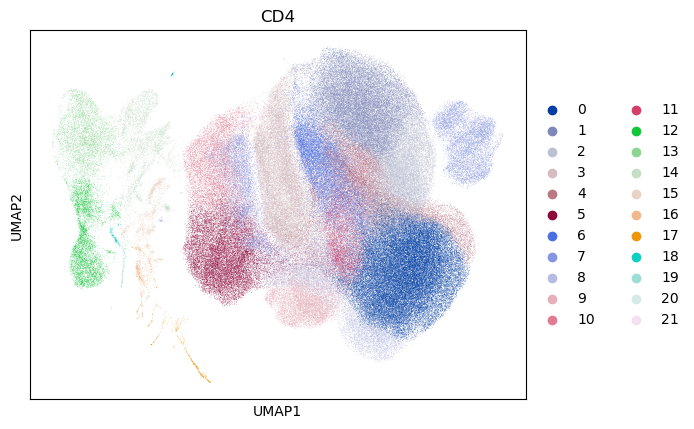

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


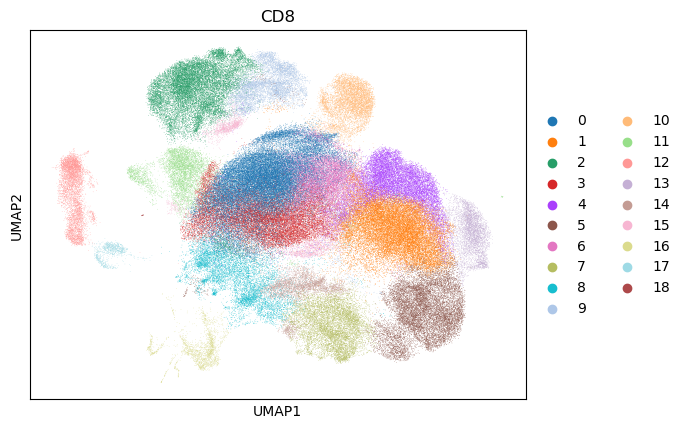

In [11]:
%matplotlib inline
def run_cluster(sub_adata, key: str):
    sc.pp.scale(sub_adata)
    sc.tl.pca(sub_adata, svd_solver="arpack")
    sc.pp.neighbors(sub_adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(sub_adata)
    sc.tl.leiden(sub_adata, resolution=0.5)
    sc.pl.umap(sub_adata, color="leiden", title=key)
    return sub_adata.obs["leiden"].rename(f"cluster_{key}")

cd4_mask = adata.obs["cell_type"] == "CD4"
cd8_mask = adata.obs["cell_type"] == "CD8"

leiden_cd4 = run_cluster(adata[cd4_mask].copy(), "CD4")
leiden_cd8 = run_cluster(adata[cd8_mask].copy(), "CD8")

clusters_wide = pd.concat([leiden_cd4, leiden_cd8], axis=1)




In [12]:
clusters_wide


,cluster_CD4,cluster_CD8
AAACCTGAGATCCGAG-HN12_post,10,NaN
AAACCTGAGGCTAGCA-HN12_post,3,NaN
AAACCTGCAGCATGAG-HN12_post,3,NaN
AAACCTGGTTCCACAA-HN12_post,3,NaN
AAACCTGTCCTATGTT-HN12_post,7,NaN
...,...,...
TTTGGTTAGTGGGATC-HN35_post,NaN,15
TTTGGTTCAAGACACG-HN35_post,NaN,0
TTTGGTTCACACATGT-HN35_post,NaN,8
TTTGGTTCATGGTCAT-HN35_post,NaN,0


In [13]:
clusters_wide.to_csv("CD4_CD8_clusters.csv", index=True)

In [14]:

# adata_subset = adata_concat[:, matched_genes].copy()

In [15]:
# %matplotlib inline
# # # Scale the data
# sc.pp.scale(adata_subset)

# # Run PCA for dimensionality reduction
# sc.tl.pca(adata_subset, svd_solver='arpack')

# # Compute the neighborhood graph 
# sc.pp.neighbors(adata_subset, n_neighbors=10, n_pcs=40)

# # compute UMAP for visualization
# sc.tl.umap(adata_subset)

# # Perform clustering (using Leiden in this example)
# sc.tl.leiden(adata_subset, resolution=0.5)

# # Plot the resulting clusters
# sc.pl.umap(adata_subset, color=['leiden'])

In [16]:
# import pandas as pd

# # Reset the index to transform cell barcodes from index to column
# obs_df = adata_subset.obs.reset_index()

# # Assuming the cell barcode column is now named 'index' and cluster labels are under 'leiden'
# # Rename the columns for clarity:
# final_df = obs_df[['index', 'leiden']].rename(columns={'index': 'cell_barcode', 'leiden': 'cluster'})

# # Display the first few rows of the resulting DataFrame
# print(final_df.head())

In [17]:
# final_df.to_csv('clustering.csv',index = True)